# Pre-processing & Modeling

## 1. Imports packages

In [80]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set()

## 2. Load Data

In [53]:
train = pd.read_csv("bank.csv")

In [54]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


## 3. Imput Outliers by Mean

In [56]:
# Calculate the mean of the values less than or equal to 34
pmean_value = train[train['previous'] > 34]['previous'].mean()

# Replace values greater than 34 with the calculated mean
train['previous'] = train['previous'].apply(lambda x: pmean_value if x > 34 else x)

# Calculate the mean of the values less than or equal to 34
cmean_value = train[train['campaign'] > 34]['campaign'].mean()

# Replace values greater than 34 with the calculated mean
train['campaign'] = train['campaign'].apply(lambda x: cmean_value if x > 34 else x)

# Calculate the mean of the values less than or equal to 400
pdmean_value = train[train['pdays'] > 400]['pdays'].mean()

# Replace values greater than 34 with the calculated mean
train['pdays'] = train['pdays'].apply(lambda x: pdmean_value if x > 400 else x)

#Replace pdays value:-1 to 0
# train['pdays'] = train['pdays'].replace(-1, 0)

## 4. Create Customer Segmentation with K-Means

Customer Data:
- age: (numeric)
- job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-emplo yed','services','student','technician','unemployed','unknown')
- marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education: (categorical: primary, secondary, tertiary and unknown)
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- balance: Balance of the individual.

In [57]:
df_cust = train[['age','job','education','marital']]

In [58]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   education  11162 non-null  object
 3   marital    11162 non-null  object
dtypes: int64(1), object(3)
memory usage: 348.9+ KB


In [59]:
cont_features = []
cat_features = []

for c in df_cust.columns:
    if df_cust[c].dtype == 'int64':
        cont_features += [c]
    else:
        cat_features += [c]

In [60]:
df_cust[cat_features].nunique()

job          12
education     4
marital       3
dtype: int64

<AxesSubplot:xlabel='age', ylabel='Density'>

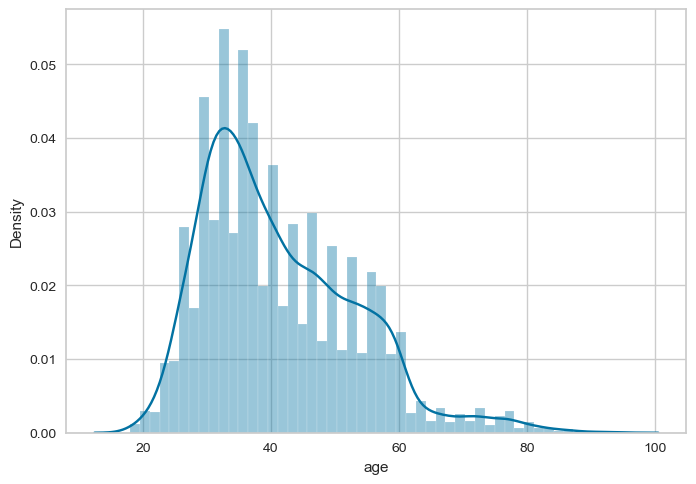

In [61]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_cust[cat_features]))
OH_cols.index = train.index

df_cont = df_cust.drop(cat_features, axis=1)

df_OH = pd.concat([df_cont, OH_cols], axis=1)

fig, ax = plt.subplots()
sns.distplot(df_OH['age'])

In [ ]:
# fig, ax = plt.subplots()
# sns.distplot(df_OH['age'])

<AxesSubplot:xlabel='age', ylabel='Density'>

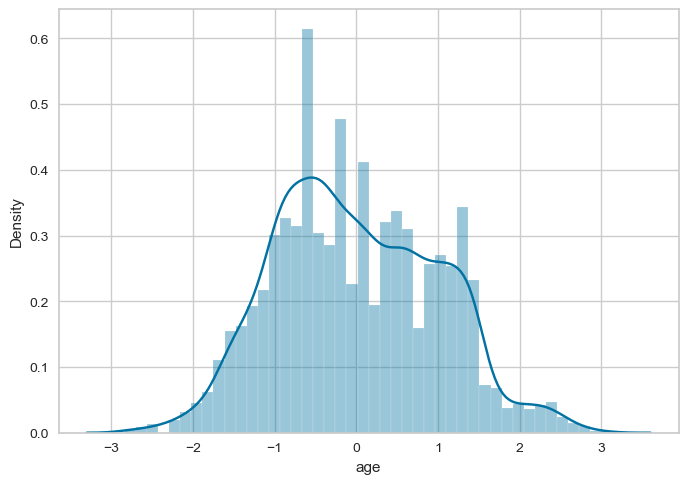

In [62]:
df_OH[cont_features] = np.log(df_OH[cont_features])
scaler = StandardScaler()
df_OH[cont_features] = scaler.fit_transform(df_OH[cont_features])
# train[cont_features] = scaler.fit_transform(train[cont_features])

fig, ax = plt.subplots()
sns.distplot(df_OH['age'])

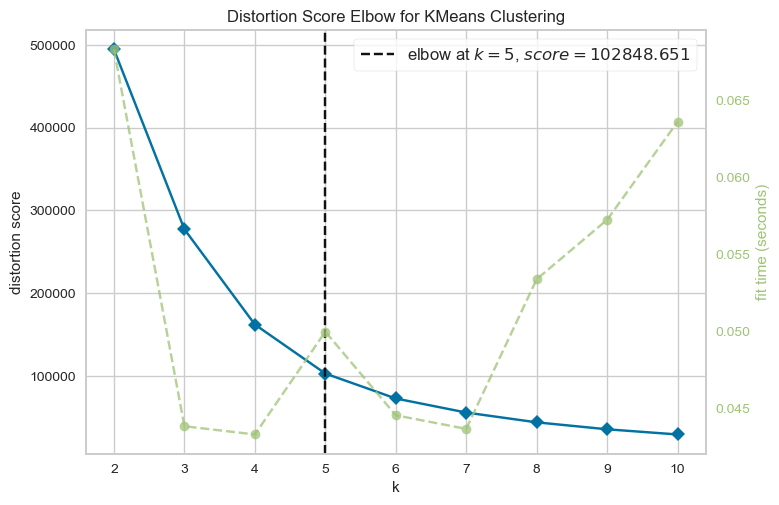

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_cust[cont_features])
Elbow_M.show()

In [64]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=30, max_iter=100)
clusters = kmeans.fit_predict(df_cust[cont_features])
df_cust['cluster'] = clusters

In [65]:
df_cust

,age,job,education,marital,cluster
0,59,admin.,secondary,married,1
1,56,admin.,secondary,married,1
2,41,technician,secondary,married,4
3,55,services,secondary,married,1
4,54,admin.,tertiary,married,1
...,...,...,...,...,...
11157,33,blue-collar,primary,single,0
11158,39,services,secondary,married,4
11159,32,technician,secondary,single,0
11160,43,technician,secondary,married,2


In [66]:
df_cust.groupby(['cluster']).agg(['min', 'median', 'mean', 'max', 'sum', 'count']).round()

age                               
        min median  mean max     sum count
cluster                                   
0        18   30.0  29.0  33  100593  3444
1        52   56.0  57.0  65  106356  1879
2        42   46.0  46.0  51  110482  2391
3        66   73.0  74.0  95   29489   398
4        34   37.0  37.0  41  113311  3050

In [26]:
df_cust.shape

(11162, 5)

In [67]:
# create sample dataframes
df_a = pd.read_csv("bank.csv")
df_b = df_cust.copy()

df_a.set_index(['age','job','marital','education'], inplace=True)
df_b.set_index(['age','job','marital','education'], inplace=True)

In [68]:
joined_df = df_a.join(df_b)

In [69]:
joined_df = joined_df.reset_index()
joined_df = joined_df.drop_duplicates()

In [70]:
joined_df.cluster.unique()

array([0, 4, 2, 1, 3], dtype=int32)

In [71]:
train = joined_df.copy()

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11162 entries, 0 to 192209
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
 17  cluster    11162 non-null  int32 
dtypes: int32(1), int64(7), object(10)
memory usage: 1.6+ MB


In [73]:
train.cluster.unique()

array([0, 4, 2, 1, 3], dtype=int32)

## 5.Differentiate numerical features and categorical features

In [74]:
categorical_features = train.select_dtypes(include = ["object"]).columns
categorical_features = categorical_features.drop("deposit")

numerical_features = train.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 8
Categorical features : 9


In [75]:
train_num

,age,balance,day,duration,campaign,pdays,previous,cluster
0,18,608,12,267,1,-1,0,0
2,18,608,13,210,1,93,1,0
4,18,5,24,143,2,-1,0,0
5,18,108,10,167,1,-1,0,0
10,18,108,8,169,1,-1,0,0
...,...,...,...,...,...,...,...,...
192201,92,775,22,313,3,-1,0,3
192203,92,775,26,164,4,96,3,3
192205,93,775,22,860,2,177,7,3
192207,93,775,4,476,2,13,9,3


In [76]:
train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0
cluster,11162.0,1.796721,1.577998,0.0,0.0,2.0,4.00,4.0


In [ ]:
# Removing balance < 0
# train_num = train_num[train_num['balance']>0]

In [77]:
train_cat

,job,marital,education,default,housing,loan,contact,month,poutcome
0,student,single,primary,no,no,no,cellular,aug,unknown
2,student,single,primary,no,no,no,cellular,nov,success
4,student,single,secondary,no,no,no,cellular,aug,unknown
5,student,single,unknown,no,no,no,cellular,aug,unknown
10,student,single,unknown,no,no,no,cellular,sep,unknown
...,...,...,...,...,...,...,...,...,...
192201,retired,married,unknown,no,no,no,cellular,oct,unknown
192203,retired,married,unknown,no,no,no,cellular,jan,success
192205,retired,married,unknown,no,no,no,cellular,jul,success
192207,retired,married,unknown,no,no,no,cellular,aug,success


## 6.Log transform of the skewed numerical features to lessen impact of outliers

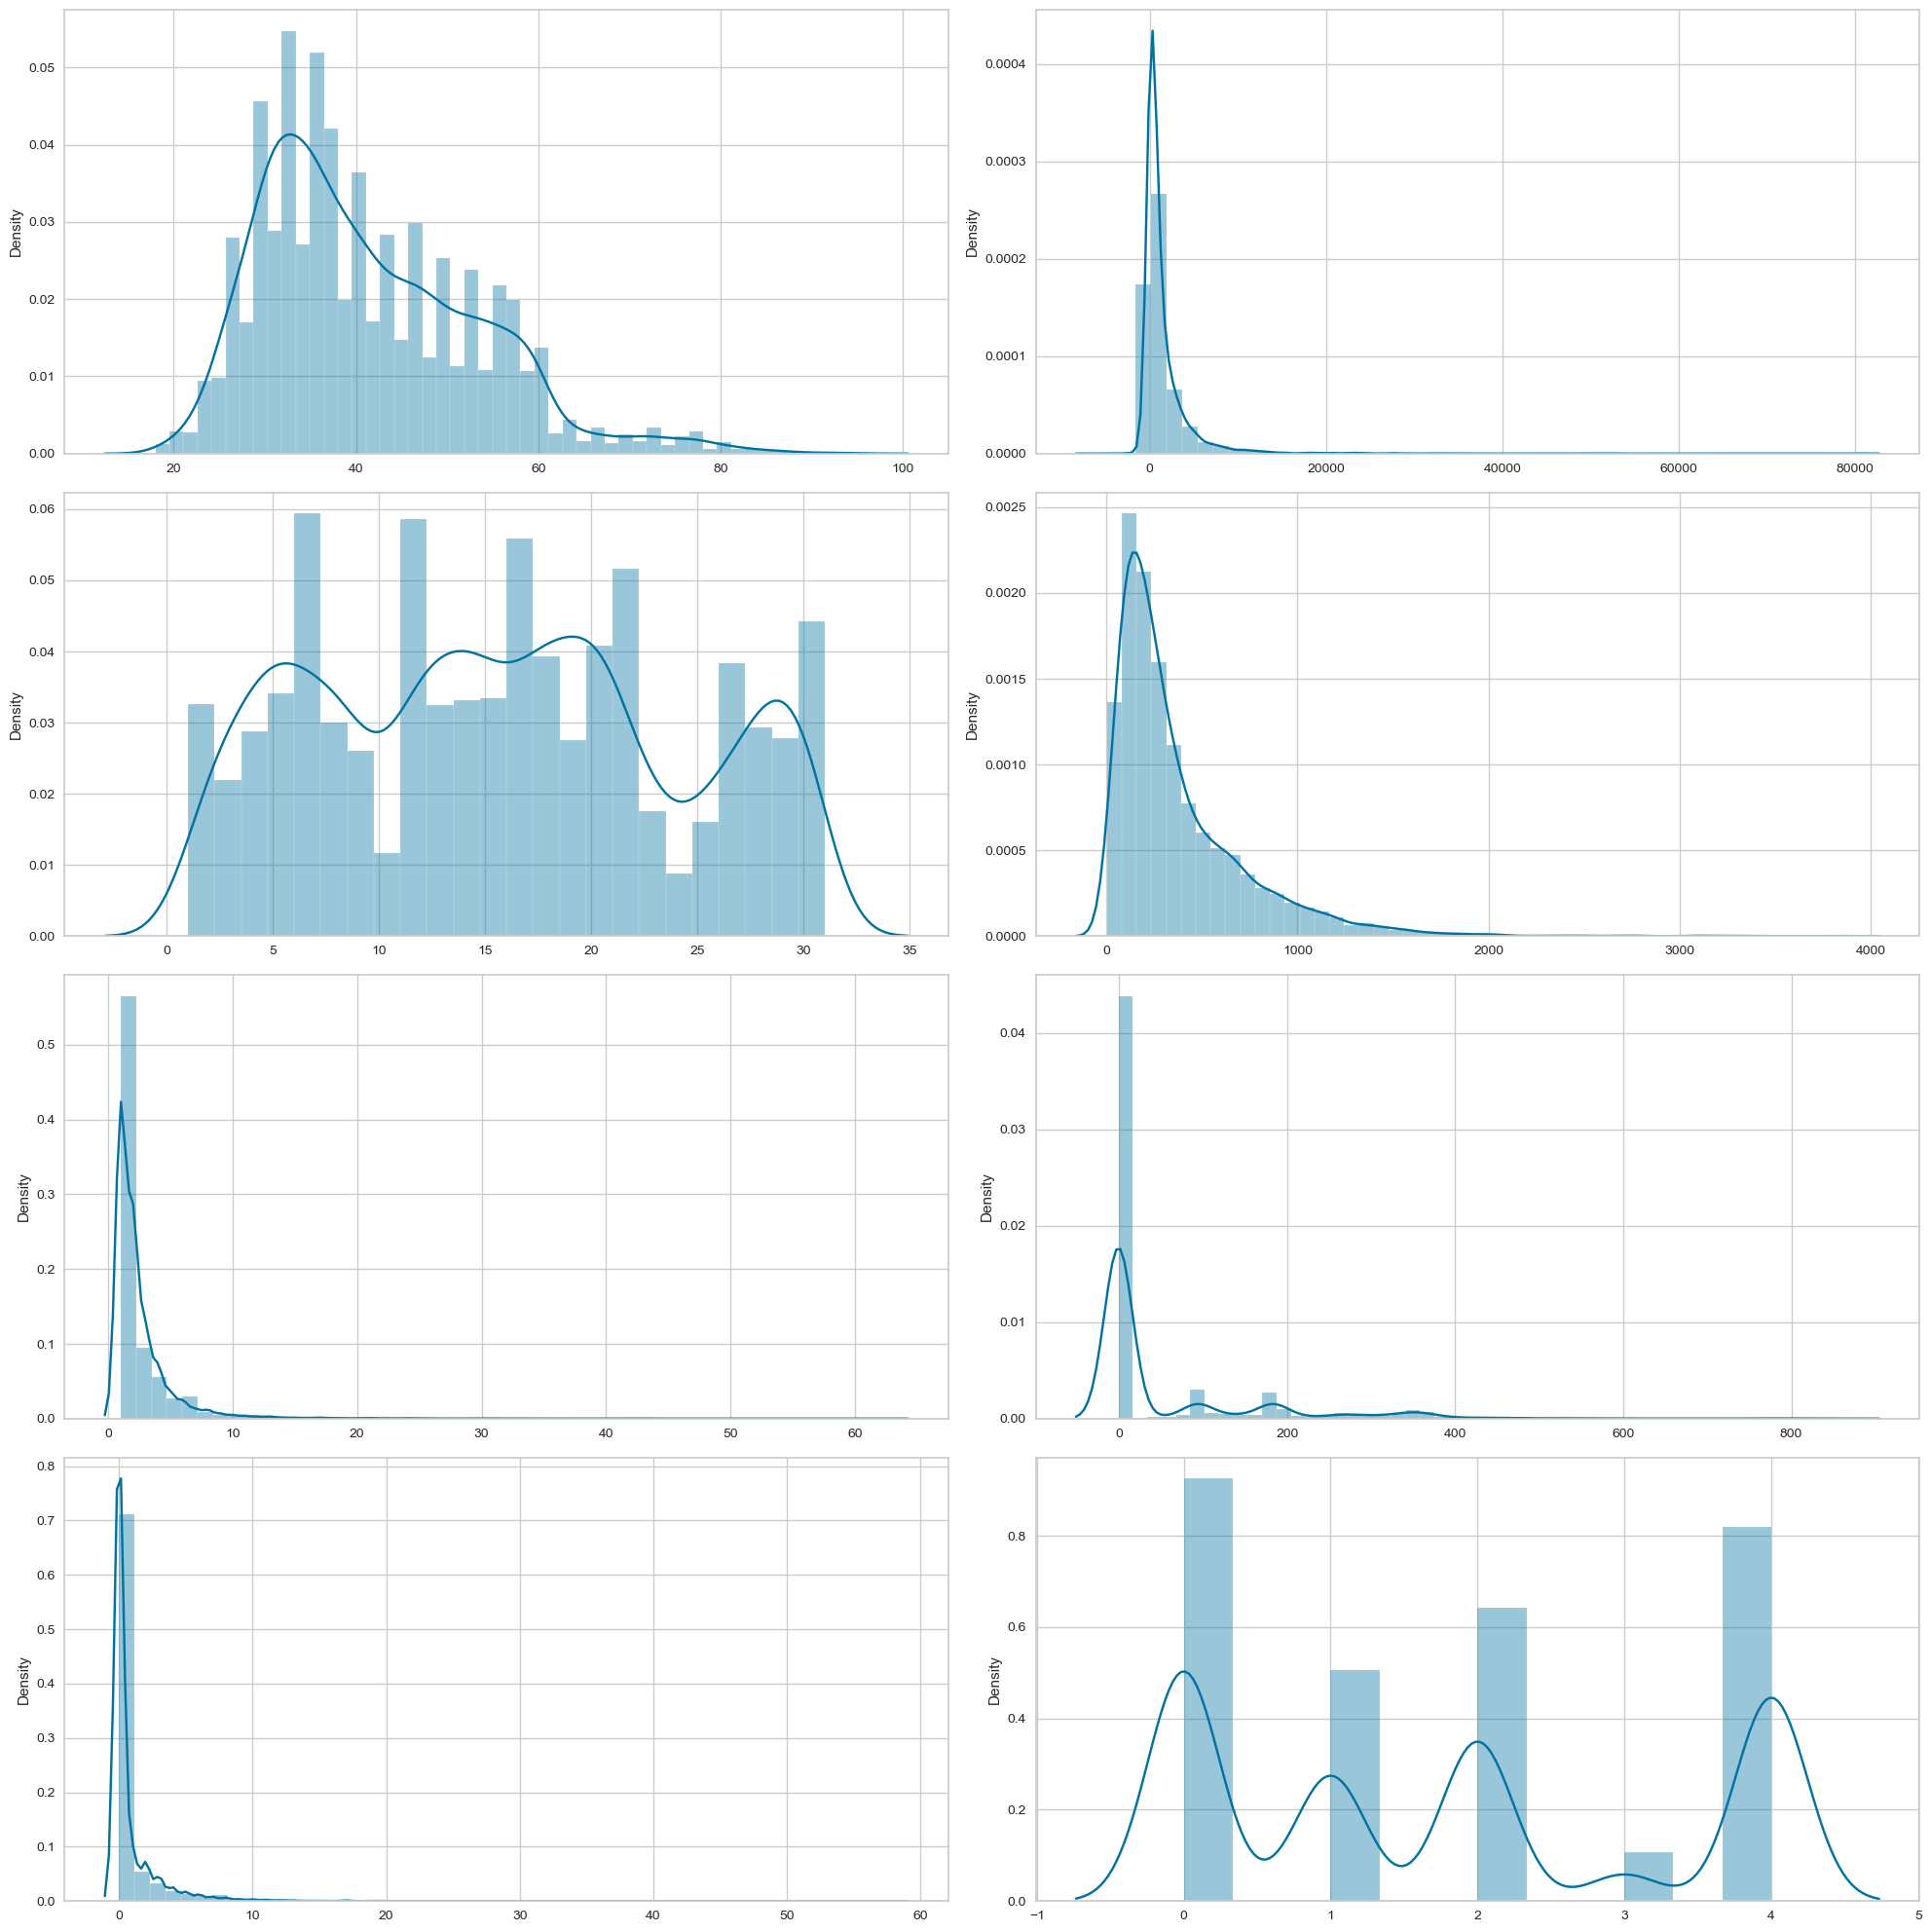

In [78]:
# List of columns to plot
columns_to_plot = train_num.columns.tolist()

# Define the number of rows and columns for the grid
n_rows = 4
n_cols = 2

# Create the subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

# Create a histogram plot with percentage labels for each column
for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]
    sns.distplot(x=train_num[column], ax=ax)
    
# Remove unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.axis('off')

# Adjust layout and show the grid of plots
plt.tight_layout()
plt.show()

In [81]:
train_num

,age,balance,day,duration,campaign,pdays,previous,cluster
0,18,608,12,267,1,-1,0,0
2,18,608,13,210,1,93,1,0
4,18,5,24,143,2,-1,0,0
5,18,108,10,167,1,-1,0,0
10,18,108,8,169,1,-1,0,0
...,...,...,...,...,...,...,...,...
192201,92,775,22,313,3,-1,0,3
192203,92,775,26,164,4,96,3,3
192205,93,775,22,860,2,177,7,3
192207,93,775,4,476,2,13,9,3


In [82]:
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewness

print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
skewed_features

for feature in skewed_features:
    # Find the minimum value in the feature
    min_value = train_num[feature].min()

    # Add a constant value to each element in the feature to make all values positive
    # We add the absolute value of min_value plus a small constant (e.g., 1) to avoid log(0)
    constant = abs(min_value) + 1
    train_num[feature] = train_num[feature] + constant

    # Apply the log transformation
    train_num[feature] = np.log(train_num[feature])


6 skewed numerical features to log transform


In [98]:
train_num.describe()

,age,balance,day,duration,campaign,pdays,previous,cluster
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,4.079794,8.995432,15.658036,5.535428,1.412509,1.306731,0.322983,1.796721
std,0.189598,0.254137,8.420740,0.938955,0.383348,2.265352,0.618742,1.577998
min,3.610918,0.000000,1.000000,1.609438,1.098612,0.000000,0.000000,0.000000
25%,3.931826,8.849371,8.000000,4.948760,1.098612,0.000000,0.000000,0.000000
50%,4.060443,8.908965,15.000000,5.552960,1.386294,0.000000,0.000000,2.000000
75%,4.219508,9.054388,22.000000,6.212606,1.609438,3.124381,0.693147,4.000000
max,4.736198,11.385683,31.000000,8.264621,4.174387,6.752270,4.077537,4.000000


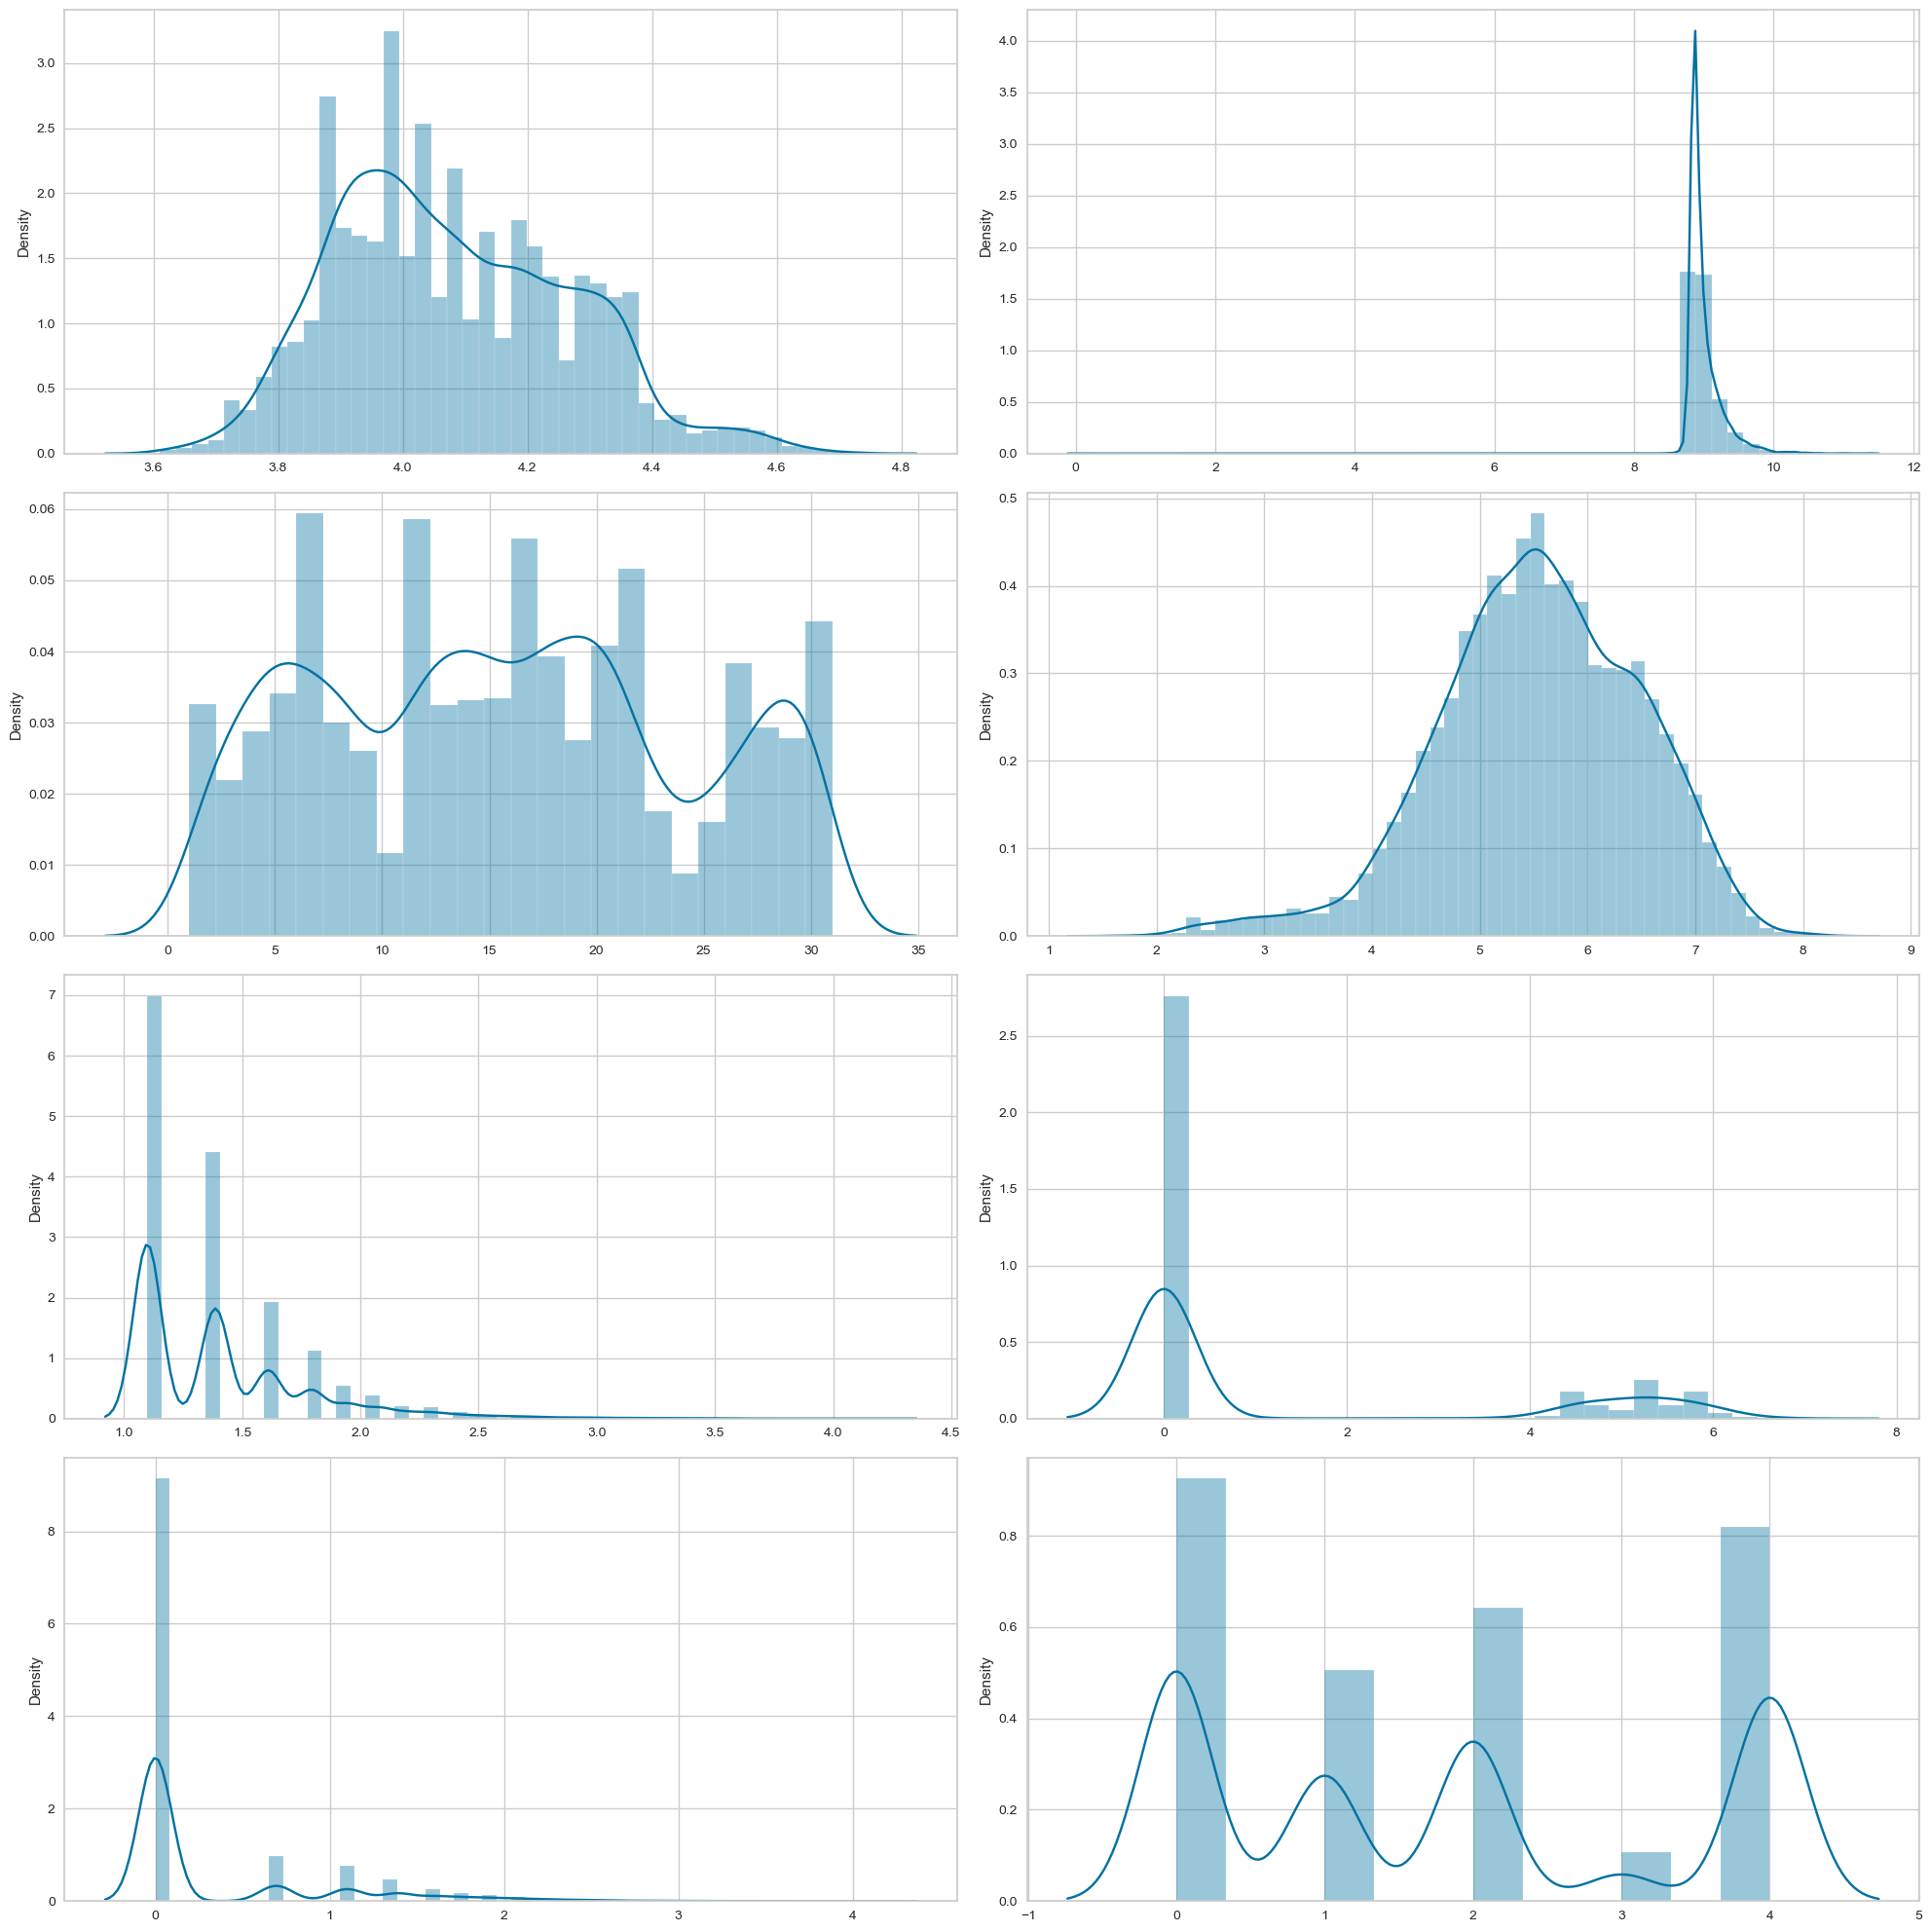

In [84]:
# List of columns to plot
columns_to_plot = train_num.columns.tolist()

# Define the number of rows and columns for the grid
n_rows = 4
n_cols = 2

# Create the subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

# Create a histogram plot with percentage labels for each column
for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]
    sns.distplot(x=train_num[column], ax=ax)
    
# Remove unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.axis('off')

# Adjust layout and show the grid of plots
plt.tight_layout()
plt.show()

## 6. Transformation of categorical features

In [85]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)
train_cat.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


## 7. Convert target variable to boolean

In [86]:
train['deposit'] = train['deposit'].replace({'yes': 1, 'no': 0})

## 8. Split into testing and training datasets

In [89]:
from sklearn.model_selection import train_test_split

# Join categorical and numerical features
X = pd.concat([train_num, train_cat], axis = 1)
y= train.deposit
print("New number of features : " + str(X.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 52
X_train : (7813, 52)
X_test : (3349, 52)
y_train : (7813,)
y_test : (3349,)


## 9.Standardize the magnitude of numeric features using a scaler

In [90]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

# Modeling

In [91]:
#import machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Define the models
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(random_state=42, probability=True)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Perform cross-validation and evaluate the models
results = []
names = []

for name, model in models:
    # Use StratifiedKFold for cross-validation to preserve the class distribution
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    # Compute the cross-validated performance metrics
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean()
    cv_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision').mean()
    cv_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall').mean()
    cv_f1_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1').mean()
    cv_auc_roc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc').mean()

    # Print the results
    print(f"{name}:")
    print(f"  - Accuracy: {cv_accuracy:.4f}")
    print(f"  - Precision: {cv_precision:.4f}")
    print(f"  - Recall: {cv_recall:.4f}")
    print(f"  - F1-score: {cv_f1_score:.4f}")
    print(f"  - AUC-ROC: {cv_auc_roc:.4f}\n")

    # Save the results
    results.append((name, cv_accuracy, cv_precision, cv_recall, cv_f1_score, cv_auc_roc))
    names.append(name)

# Convert the results to a DataFrame for easy comparison
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])

Logistic Regression:
  - Accuracy: 0.8238
  - Precision: 0.8066
  - Recall: 0.8226
  - F1-score: 0.8145
  - AUC-ROC: 0.9006

Decision Tree:
  - Accuracy: 0.7855
  - Precision: 0.7758
  - Recall: 0.7655
  - F1-score: 0.7705
  - AUC-ROC: 0.7844

Random Forest:
  - Accuracy: 0.8456
  - Precision: 0.8145
  - Recall: 0.8702
  - F1-score: 0.8414
  - AUC-ROC: 0.9147

K-Nearest Neighbors:
  - Accuracy: 0.7912
  - Precision: 0.7825
  - Recall: 0.7715
  - F1-score: 0.7766
  - AUC-ROC: 0.8596

Support Vector Machine:
  - Accuracy: 0.8481
  - Precision: 0.8101
  - Recall: 0.8847
  - F1-score: 0.8456
  - AUC-ROC: 0.9151

Gradient Boosting:
  - Accuracy: 0.8412
  - Precision: 0.8196
  - Recall: 0.8496
  - F1-score: 0.8343
  - AUC-ROC: 0.9155



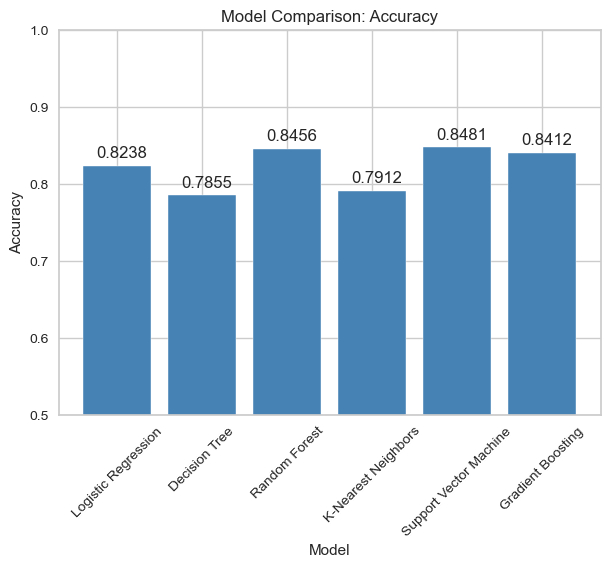

In [96]:
import matplotlib.pyplot as plt

# Set up the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the accuracy of each model as a bar chart
ax.bar(results_df['Model'], results_df['Accuracy'], color='steelblue')

# Customize the appearance of the chart
ax.set_title('Model Comparison: Accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1.0])  # Adjust the y-axis range if needed
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Add the accuracy values above the bars
for i, v in enumerate(results_df['Accuracy']):
    ax.text(i - 0.25, v + 0.01, f"{v:.4f}")

# Display the chart
plt.show()

SVM classifier & Random Forest perform the best. I will do hyperparameter tuning to see if the model can perform even better.

### Hyperparameter Tuning for Random Forest

#### Hyperparameter turing for RF w/ RandomizedSearchCV

In [106]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

# Load your dataset and split it into X and y
# X, y = your_data()

# Perform hyperparameter tuning
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

# Perform cross-validation and evaluate the best model
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

cv_accuracy = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='accuracy').mean()
cv_precision = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='precision').mean()
cv_recall = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='recall').mean()
cv_f1_score = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='f1').mean()
cv_auc_roc = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='roc_auc').mean()

# Print the results
print("Random Forest Classifier with Tuned Hyperparameters:")
print(f"  - Accuracy: {cv_accuracy:.4f}")
print(f"  - Precision: {cv_precision:.4f}")
print(f"  - Recall: {cv_recall:.4f}")
print(f"  - F1-score: {cv_f1_score:.4f}")
print(f"  - AUC-ROC: {cv_auc_roc:.4f}\n")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Forest Classifier with Tuned Hyperparameters:
  - Accuracy: 0.8482
  - Precision: 0.8123
  - Recall: 0.8811
  - F1-score: 0.8453
  - AUC-ROC: 0.9174



The performance did not improve using RandomizedSearchCV, will try with GridSearchCV to see if the model can perform better

#### Hyperparameter turing for RF w/ GridSearchCV

In [114]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

# Load your dataset and split it into X and y
# X, y = your_data()

# Perform hyperparameter tuning
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Perform cross-validation and evaluate the best model
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

cv_accuracy = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='accuracy').mean()
cv_precision = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='precision').mean()
cv_recall = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='recall').mean()
cv_f1_score = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='f1').mean()
cv_auc_roc = cross_val_score(best_rf, X_train, y_train, cv=kfold, scoring='roc_auc').mean()

# Print the results
print("Random Forest Classifier with Tuned Hyperparameters (GridSearchCV):")
print(f"  - Accuracy: {cv_accuracy:.4f}")
print(f"  - Precision: {cv_precision:.4f}")
print(f"  - Recall: {cv_recall:.4f}")
print(f"  - F1-score: {cv_f1_score:.4f}")
print(f"  - AUC-ROC: {cv_auc_roc:.4f}\n")


Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   3.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   5.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; t

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   4.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   6.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_featu

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   3.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   4.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   6.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   4.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   5.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   6.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   3.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   5.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_featu

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   4.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   6.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   5.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   6.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_feat

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   8.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   9.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=20, max_feat

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_fe

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.7s
[CV] END bootstrap=True, max_depth=20, ma

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   5.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   7.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_f

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   9.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.9s
[CV] END bootstrap=True, max_depth=30, max_featu

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   7.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=20, max_featu

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   7.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   9.0s
[CV] END bootstrap=True, max_depth=20, m

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   6.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.2s
[CV] END bootstrap=True, max_depth=20, max

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=20, max_featu

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   8.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=True, max_depth=20, max_fea

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.0s
[CV] END bootstrap=True, max_depth=20, max_feat

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   4.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.3s
[CV] END bootstrap=True, max_depth=20, max_feat

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   8.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   9.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   8.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=30, max_f

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   5.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   9.1s
[CV] END bootstrap=True, max_depth=30, max_fe

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   6.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.5s
[CV] END bootstrap=True, max_depth=30, max_fea

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.6s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   7.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, ma

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   8.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   7.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   7.7s
[CV] END bootstrap=True, max_depth=30, max_featu

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   6.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   8.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.2s
[CV] END bootstrap=True, max_depth=40, max

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   9.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.1s
[CV] END bootstrap=True, max_depth=30, max_featu

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   5.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   6.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=40, max_feat

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   7.6s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   8.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=40, max_fea

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   6.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   7.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=40, max_feat

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   7.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   8.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   6.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   7.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_featu

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   5.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=   7.4s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   8.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   4.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.7s
[CV] END bootstrap=True, max_depth=40, max

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   9.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   6.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   7.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=50, max_fe

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   5.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   6.6s
[CV] END bootstrap=True, max_depth=40, ma

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   6.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=40, max_feat

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   8.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.0s
[CV] END bootstrap=True, max_depth=40, max

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.6s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   8.5s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.1s
[CV] END bootstrap=True, max_depth=40, m

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   6.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.9s
[CV] END bootstrap=True, max_depth=50, max

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   6.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   6.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.5s
[CV] END bootstrap=True, max_depth=50, max

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   7.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   6.9s
[CV] END bootstrap=True, max_depth=50, max_fe

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   8.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   7.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.6s
[CV] END bootstrap=True, max_depth=50, max_

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   5.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=   8.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=60, max

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  10.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_featu

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  10.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=60, max_featu

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.2s
[CV] END bootstrap=True, max_depth=50, max_featu

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.8s
[CV] END bootstrap=True, max_depth=60, max_featu

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   6.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   7.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   9.0s
[CV] END bootstrap=True, max_depth=50, max_feat

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   7.5s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   7.2s
[CV] END bootstrap=True, max_depth=60, max_fe

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   8.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.2s
[CV] END bootstrap=True, max_depth=50, m

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   5.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   6.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=50, max_fea

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   8.5s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   7.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  10.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=60, max_f

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   6.6s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  10.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=60, max_fea

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   7.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.9s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.6s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   7.6s
[CV] END bootstrap=True, max_depth=60, max_feat

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   8.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   9.2s
[CV] END bootstrap=True, max_depth=60, max_feat

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   8.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   6.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   7.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=60, max_fe

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   7.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=60, max_

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   7.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   8.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=70, ma

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   5.6s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.6s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   8.6s
[CV] END bootstrap=True, max_depth=60, ma

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   3.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   5.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=17.4min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   4.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   4.9s
[CV] END bootstrap=True, max_depth=70, max_

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   4.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   6.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   7.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=70, max_fea

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   6.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=17.4min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   4.5s
[CV] END bootstrap=True, max_depth=70, max_f

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   2.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   5.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   5.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   7.5s
[CV] END bootstrap=True, max_depth=70, max_feat

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   5.1s
[CV] END bootstrap=True, max_depth=70, max_featu

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   3.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   5.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=   7.0s
[CV] END bootstrap=True, max_depth=70, ma

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   3.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   4.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   6.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   7.7s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.4min
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=70, max_

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   6.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  11.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.2s
[CV] END bootstrap=True, max_depth=70, max_featu

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   6.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=70, max_fea

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   6.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.3s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   7.4s
[CV] END bootstrap=True, max_depth=80, max_feat

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.7s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.2s
[CV] END bootstrap=True, max_depth=80, max_feat

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   6.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   7.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=80, max_f

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.8s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   9.9s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.9s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   8.5s
[CV] END bootstrap=True, max_depth=90, max_feat

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   6.0s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   7.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=80, max_feat

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   8.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   4.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   9.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=80, max_fe

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   8.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=80, max_fea

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   6.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=True, max_depth=80, max

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   6.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.8s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=15.1min
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.6s
[CV] END bootstrap=True, max_depth=90, max

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   7.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.1s
[CV] END bootstrap=True, max_depth=90, max_fea

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   5.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=90, max_feat

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=90, max_feat

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  10.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   4.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   9.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=90, max_fea

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   7.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   5.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   7.0s
[CV] END bootstrap=True, max_depth=90, max_featu

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   5.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   6.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.1s
[CV] END bootstrap=True, max_depth=90, max_

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   5.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=100,

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   8.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   7.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  11.1s
[CV] END bootstrap=True, max_depth=100

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   7.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=100,

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   8.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=100, 

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   8.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, 

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   6.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   7.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   8.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, 

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   8.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   5.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   7.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.2s
[CV] END bootstrap=True, max_depth=110, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   8.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_d

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=110, m

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   6.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   8.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=110

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   5.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   7.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.6s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=110,

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   5.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time= 2.8min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.6s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   5.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   5.8s
[CV] END bootstrap=True, max_depth=110, 

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   6.6s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 2.9min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   4.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   5.8s
[CV] END bootstrap=True, max_depth=110, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   7.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   8.2s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   8.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   8.6s
[CV] END bootstrap=True, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   4.0s
[CV] END bootstrap=True, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   8.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   7.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   6.5s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   6.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   7.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, m

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   5.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   6.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   8.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.5s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  10.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  11.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   6.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   7.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   5.7s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   5.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   7.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   8.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.2s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  12.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   8.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  10.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  13.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.3s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   5.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   7.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   4.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   6.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   8.5s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   7.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   9.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  11.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.5s
[CV] END bootstrap=False, max_depth=20, 

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  11.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  13.8s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=20,

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   7.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  11.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=20

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.3s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   8.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  12.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  15.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END bootstrap=False, max_depth=30, 

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   5.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   7.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   9.0s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  13.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   8.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   9.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  11.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.1s
[CV] END bootstrap=False, max_depth=30,

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  11.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  11.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   8.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   9.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  12.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   4.9s
[CV] END bootstrap=False, max_depth=30

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   7.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   9.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=  10.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   6.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   7.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  10.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  13.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.9s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   7.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  12.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.1s
[CV] END bootstrap=False, max_depth=2

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   7.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   9.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  12.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.3s
[CV] END bootstrap=False, max_depth=30, 

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  11.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  13.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   4.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.2s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  10.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  12.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.1s
[CV] END bootstrap=False, max_depth=30, m

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   7.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.7s
[CV] END bootstrap=False, max_depth=30, m

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   7.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   9.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=  13.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  14.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.7s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   9.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.5s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  11.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   4.9s
[CV] END bootstrap=False, max_depth=40, 

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  15.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   6.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   8.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  11.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=  12.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   4.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  10.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  13.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   6.6s
[CV] END bootstrap=False, max_depth=30

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  10.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  15.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  19.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   7.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=  10.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  12.1s
[CV] END bootstrap=False, max_depth=40, 

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   7.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  11.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.9s
[CV] END bootstrap=False, max_depth=40

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  12.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   6.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   7.2s
[CV] END bootstrap=False, max_depth=4

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   8.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   9.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=  12.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   6.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=  13.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  18.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  16.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=40, 

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  12.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=40

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=40, m

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   9.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  12.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  13.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   7.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   9.0s
[CV] END bootstrap=False, max_depth=5

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  14.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=4

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  12.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  12.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   4.9s
[CV] END bootstrap=False, max_depth=40

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=  10.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=40

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  10.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  13.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  15.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   9.5s
[CV] END bootstrap=False, max_depth=50, 

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  11.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  12.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=50

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   8.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  11.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.8s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  10.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  11.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   9.7s
[CV] END bootstrap=False, max_depth=5

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   8.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=  10.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  11.8s
[CV] END bootstrap=False, max_depth=50, 

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   9.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  11.8s
[CV] END bootstrap=False, max_depth=5

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   6.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   7.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   8.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=6

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   7.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=15.1min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  11.3s
[CV] END bootstrap=False, max_depth=60, m

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   7.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  10.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=5

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  12.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   4.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   6.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   9.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=16.0min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=16.0min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   4.8s
[CV] END bootstrap=False, max_depth=60, 

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   6.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   9.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.0s
[CV] END bootstrap=False, max_depth=60, m

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=14.6min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   5.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   7.0s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   8.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   6.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   7.6s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   7.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   9.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  11.2s
[CV] END bootstrap=False, max_depth=70, m

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=15.6min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   9.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   7.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   7.5s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   6.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=15.6min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   8.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   7.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   7.7s
[CV] END bootstrap=False, max_depth=6

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   7.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   9.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  10.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=70,

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   6.2s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   7.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  10.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=14.8min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   6.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   8.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   8.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=   9.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=False, max_depth=70, m

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   7.8s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=   9.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.9s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   9.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  11.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  13.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   8.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=  11.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   8.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  10.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.6s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   8.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=70

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   7.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   9.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  12.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  13.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   9.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.3s
[CV] END bootstrap=False, max_depth=80, 

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  10.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   4.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   7.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=  10.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  11.6s
[CV] END bootstrap=False, max_depth=8

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   5.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   8.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   9.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  12.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  14.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   9.3s
[CV] END bootstrap=False, max_depth=80, 

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   8.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  10.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.2s
[CV] END bootstrap=False, max_depth=80,

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  10.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  13.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=80,

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   7.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   8.8s
[CV] END bootstrap=False, max_depth=80, m

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=  10.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  11.8s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   6.8s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  10.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=80,

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   7.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  12.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   6.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   8.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  10.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  13.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   8.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  11.0s
[CV] END bootstrap=False, max_depth=90

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   9.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  11.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   3.9s
[CV] END bootstrap=False, max_depth=90, m

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   9.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  11.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   7.5s
[CV] END bootstrap=False, max_depth=9

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.2s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.7s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   9.8s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  12.6s
[CV] END bootstrap=False, max_depth=90, m

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   6.8s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   8.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  10.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  12.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   5.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   7.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   9.2s
[CV] END bootstrap=False, max_depth=8

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   9.8s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  11.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  13.8s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.2s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   6.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=   8.8s
[CV] END bootstrap=False, max_depth=9

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   9.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=  11.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   4.7s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.7s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   8.1s
[CV] END bootstrap=False, max_depth=90,

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   3.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.8s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time=   9.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  11.6s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   4.8s
[CV] END bootstrap=False, max_depth=90,

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   8.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   9.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  11.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   9.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  12.1s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   7.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   8.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=  10.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  11.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   9.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  10.7s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   9.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  12.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  13.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.7s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  12.8s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   4.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   7.9s
[CV] END bootstrap=False, ma

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  13.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   8.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  11.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  14.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, max_d

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   5.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   6.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   8.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  10.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  12.8s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.7s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  16.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   7.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   9.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  12.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  14.7s
[CV] END bootstrap=False, 

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  10.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  11.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  15.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   9.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  13.3s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  15.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  14.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  17.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   9.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  13.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  14.4s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END bootstrap=False, max_de

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   9.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  12.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=  13.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.6s
[CV] END bootstrap=False, max_d

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   5.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   7.3s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time=  10.8s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  12.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  14.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   6.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   7.5s
[CV] END bootstrap=False, ma

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  15.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   7.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   8.9s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  12.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=  13.8s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   6.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   8.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  10.8s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=900; total time=  12.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_dept

Random Forest Classifier with Tuned Hyperparameters (GridSearchCV):
  - Accuracy: 0.8486
  - Precision: 0.8119
  - Recall: 0.8828
  - F1-score: 0.8458
  - AUC-ROC: 0.9175



The performance did not improve using GridSearchCV and it took way longer so we will not do any hyperparameter tuning for RandomForestClassifier. 

### Get Feature importance using Tuned Random Forest 

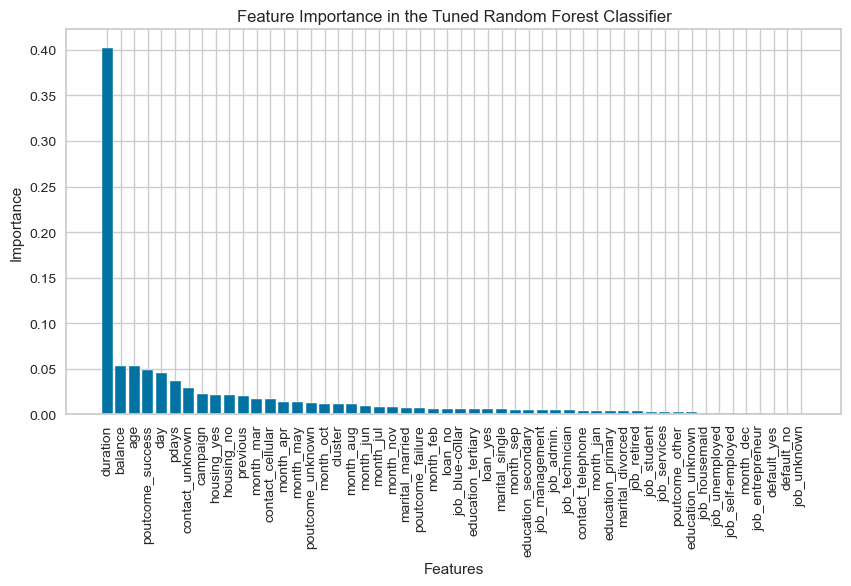

In [118]:
import matplotlib.pyplot as plt

# Get the feature names from the DataFrame
feature_names = X.columns.tolist()

# Get feature importances
importances = best_rf.feature_importances_


# Sort the feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.bar(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in the Tuned Random Forest Classifier')
plt.show()


As noted in the beginning that duration attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. We will not focus on duration for modeling.

As we can see from the diagram showing feature importances, the most important features are:

- Customer's account balance 
- Customer's age
- Success outcome of the previous marketing campaign

Let's try to make more specific recommendations:

### 1. Find out account balance, which marketing campaign should focus on:

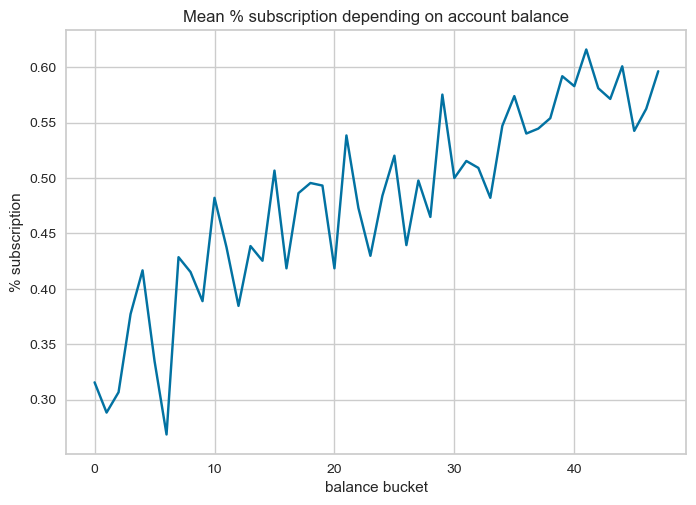

In [121]:
df_new = train.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

In [122]:
df_new[df_new['balance_buckets'] == 34]['balance'].min()

1490

From the diagram above we can conclude, that marketing campaigns should concentrate on customers with account balance greater than 1490$.

### 2. Find out age bucket, which marketing campaign should focus on:

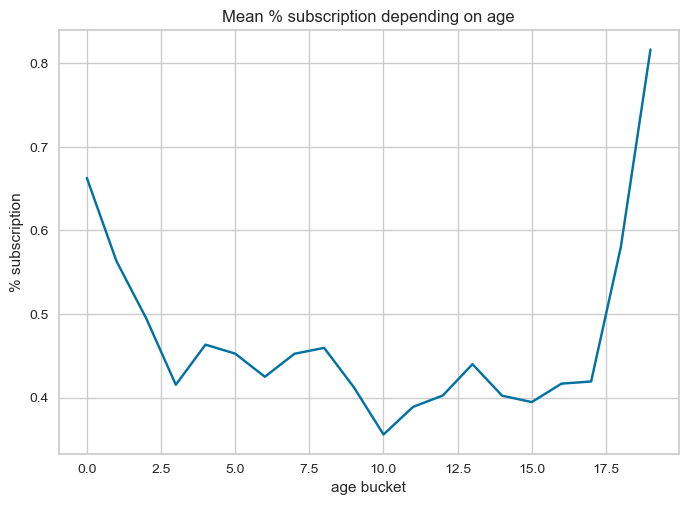

In [123]:
#introduce new column 'age_buckets' to  ''
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_age = df_new.groupby(['age_buckets'])['deposit'].mean()

#plot
plt.plot(mean_age.index, mean_age.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [124]:
df_new[df_new['age_buckets'] == 3]['age'].max()

31

In [125]:
df_new[df_new['age_buckets'] == 17]['age'].min()


56

So we see that average subscrition rate tends to be higher for customers below 31 years old or above 56 years old.

## What Actions should the Bank Consider?

Solutions for the Next Marketing Campaign (Conclusion):

**1) Age Category:** The next marketing campaign of the bank should target potential clients from age categories below 30 years old and above 50 years old.

**2) Occupation:** Not surprisingly, potential clients that were students or retired were the most likely to suscribe to a term deposit. Retired individuals, tend to have more term deposits in order to gain some cash through interest payments. Remember, term deposits are short-term loans in which the individual (in this case the retired person) agrees not to withdraw the cash from the bank until a certain date agreed between the individual and the financial institution. After that time the individual gets its capital back and its interest made on the loan. Retired individuals tend to not spend bigly its cash so they are morelikely to put their cash to work by lending it to the financial institution. Students were the other group that used to suscribe term deposits.

**3) Balance:** The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ are more likely to subscribe for term deposit, so future address those customers.

**4) Seasonality:** Potential clients opted to suscribe term deposits during the seasons of fall and winter. The next marketing campaign should focus its activity throghout these seasons.